#### CSC594-810, Winter 19-20
#### Erik S. McGuire
#### VADER sentiment annotation of ROC Stories.

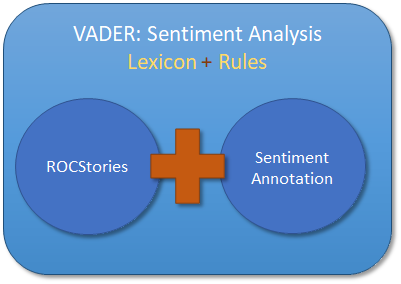

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv

In [0]:
analyser = SentimentIntensityAnalyzer()

In [0]:
def get_sentiment(sentences) -> None:
    """Compute compound scores and label heuristically."""
    l = map(lambda s: analyser.polarity_scores(s)['compound'], sentences)
    for i, p in enumerate(l):
        if p >= 0.05:
            print('{} is POSITIVE, compound score: {}.'.format(sentences[i], 
                                                               analyser.polarity_scores(sentences[i])['compound']))
        elif p <= -0.05:
            print('{} is NEGATIVE, compound score: {}.'.format(sentences[i], 
                                           analyser.polarity_scores(sentences[i])['compound']))
        else: # -0.05 < p < 0.05
            print('{} is NEUTRAL, compound score: {}.'.format(sentences[i], 
                                          analyser.polarity_scores(sentences[i])['compound']))
    #return map(lambda s: analyser.polarity_scores(s), sentences)

In [0]:
def get_stories_list(filename:str) -> list:
    """Create list of stories from ROC training file."""
    stories_list = []
    with open(filename, newline='') as csvfile:
        fieldnames = ['storyid', 'storytitle', 'sentence1', 'sentence2', 'sentence3', 'sentence4', 'sentence5']
        reader = csv.DictReader(csvfile, fieldnames=fieldnames)
        for row in reader:
            if 'storyid' not in row['storyid'].lower():
                story = [row['sentence1'], row['sentence2'], row['sentence3'], row['sentence4'], row['sentence5']]
                stories_list.append(story)
    return stories_list

In [0]:
def get_avg_senti(story: list) -> float:
    """Compute average sentiment; via VADER paragraph demo."""
    story_sentiments = 0.0
    for sentence in story: # Get avg story/context sentiment.
        valences = analyser.polarity_scores(sentence)['compound']
        story_sentiments += valences
    return round(story_sentiments / len(story), 4)

def get_label(line: str):
    """Label: most congruent ending (least distant score) to avg story sentiment."""
    line = line.split(",")
    story = line[1:-3] # Exclude id, endings, label
    ending1 = line[-3] 
    ending2 = line[-2] 
    avg_story_senti = get_avg_senti(story) # Average sentences' compound scores in story.
    ending1_senti = analyser.polarity_scores(ending1)['compound']
    ending2_senti = analyser.polarity_scores(ending2)['compound']
    ending1_dist = abs(avg_story_senti - ending1_senti) # Respective ending vs. story distances.
    ending2_dist = abs(avg_story_senti - ending2_senti)
    num_changed = 0 # Tally number of times labels change based on sentiment congruence.
    if ending1_dist < ending2_dist: # If first ending closer to average story sentiment.
        label = 1
        num_changed += 1
    elif ending1_dist > ending2_dist: # Second ending is more congruent.
        label = 2
        num_changed += 1
    else: # If equal, use correct ending.
        label = line[-1]
    return str(label), num_changed

In [0]:
def write_labels(infile: str, outfile: str) -> None:
    """Create sentiment-based version of ROC val/test data."""
    wfile = open(outfile, "a")
    with open(infile) as rfile: # Read original lines.
        lines = rfile.read().splitlines()
        wfile.write(lines[0] + "\n") # Same header.
        num_changed = 0
        for line in lines[1:]: # Skip header.
            res = get_label(line) # Get sentiment congruency-based label.
            num_changed += res[1] # Tally when label changes.
            wfile.write(",".join(line.split(",")[:-1]) + "," + res[0] + "\n") # Write original row w/ label replaced.
    print((num_changed_test/len(lines[1:])) * 100) # Number of labels switched based on sentiment congruency.
    wfile.close()

In [0]:
#write_labels('datasets/roc2018val.csv', 
#             'datasets/roc2018sentival.csv') #For val set (to be used as MTL finetune train set)
#write_labels('datasets/roc2016test.csv', 
#             'datasets/roc2016sentitest.csv') #For test set (to be used as MTL finetune val set)